In [125]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
from skimage import io,util

In [126]:
img_l_url = 'https://raw.githubusercontent.com/furkanulucay/interestPointMatching/main/image_left.jpg'
img_r_url = 'https://raw.githubusercontent.com/furkanulucay/interestPointMatching/main/image_right.jpg'

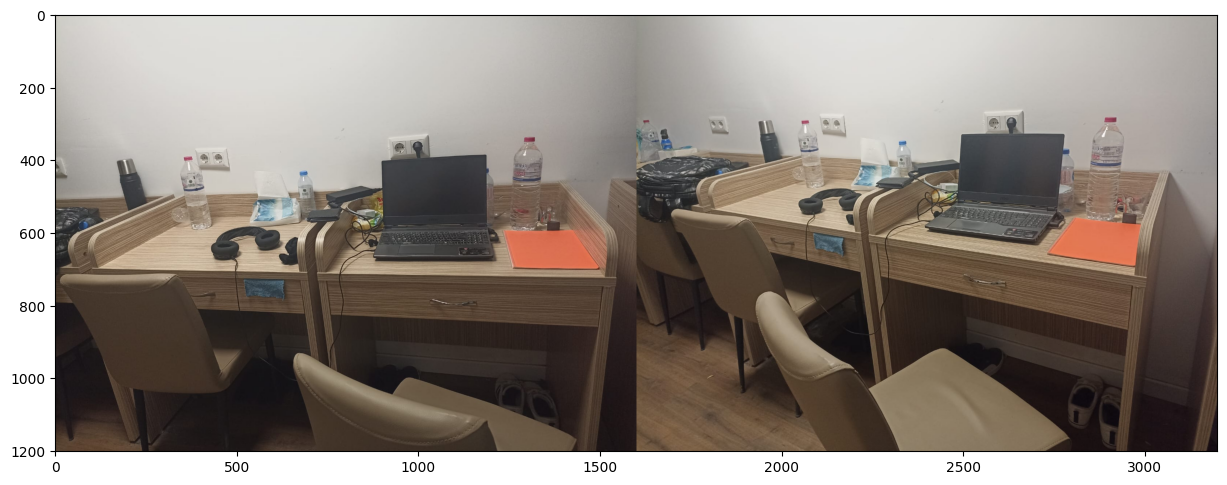

In [127]:
img_l = io.imread(img_l_url)
img_r = io.imread(img_r_url)

both_img = cv2.hconcat((img_l,img_r))

plt.figure(figsize=(15, 9))
plt.imshow(both_img)
plt.show()

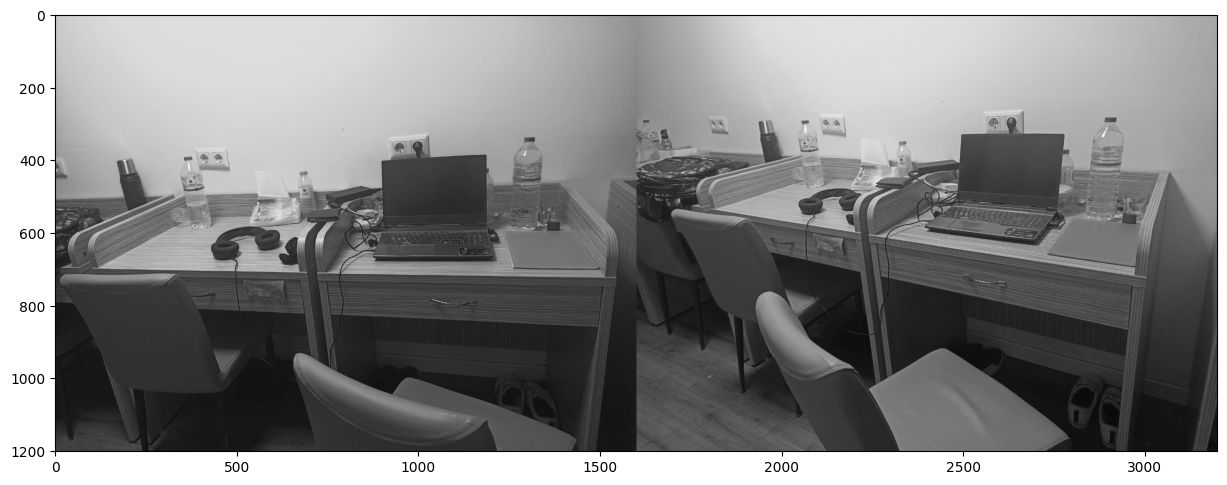

In [128]:
img_l_gray = cv2.cvtColor(img_l.copy(), cv2.COLOR_BGR2GRAY)
img_r_gray = cv2.cvtColor(img_r.copy(), cv2.COLOR_BGR2GRAY)

both_img = cv2.hconcat((img_l_gray, img_r_gray))

plt.figure(figsize=(15, 9))
plt.imshow(both_img, cmap='gray')
plt.show()

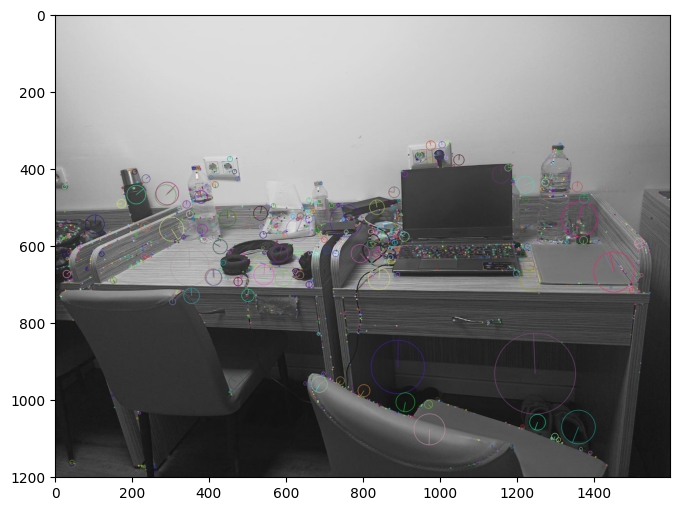

In [129]:
sift = cv2.SIFT_create()

keypoints_1, descriptors_1 = sift.detectAndCompute(img_l_gray, None)
keypoints_2, descriptors_2 = sift.detectAndCompute(img_r_gray, None)

img_l_sift= cv2.drawKeypoints(img_l_gray, keypoints_1, img_l.copy(), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure(figsize = (10,6))
plt.imshow(img_l_sift)
plt.show()

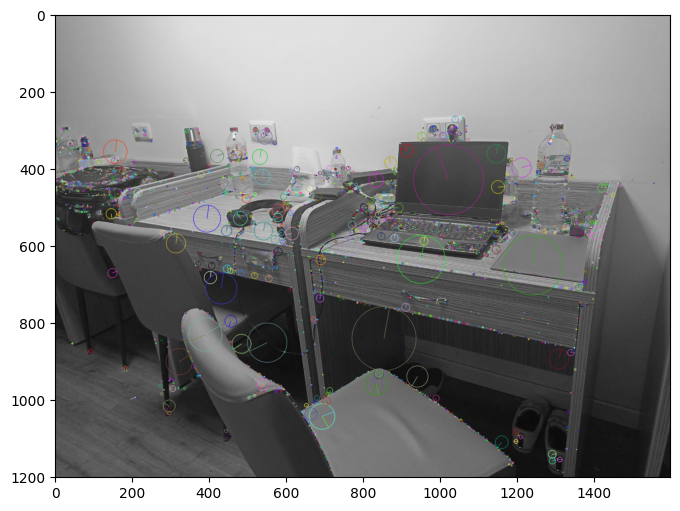

In [130]:
img_r_sift= cv2.drawKeypoints(img_r_gray, keypoints_2, img_r.copy(), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure(figsize = (10,6))
plt.imshow(img_r_sift)
plt.show()

In [131]:
def cosine_similarity(descriptor1, descriptor2):
  dot_product = np.dot(descriptor1, descriptor2)
  norm1 = np.linalg.norm(descriptor1)
  norm2 = np.linalg.norm(descriptor2)
  return 1 - (dot_product / (norm1 * norm2))

def calc_best_distances(descriptors1, descriptors2):
  best_distances = []
  second_best_distances = []
  descriptor2_indexes = []
  for i in descriptors1:
    best_distance = float('inf')
    second_best_distance = float('inf')
    count = 0
    for j in descriptors2:
      distance = cosine_similarity(i,j)
      if (distance < best_distance):
        second_best_distance = best_distance
        best_distance = distance
        descriptor2_index = count
      count += 1
    best_distances.append(best_distance)
    second_best_distances.append(second_best_distance)
    descriptor2_indexes.append(descriptor2_index)

  return best_distances, second_best_distances, descriptor2_indexes


In [134]:
best_distances, second_best_distances, descriptor2_indexes = calc_best_distances(descriptors_1, descriptors_2)

def eleminate_matches(best_distances, second_best_distances, descriptor2_indexes):
  good = []
  good_matches = []
  for i in range (len(best_distances)):
    if(best_distances[i] < second_best_distances[i] * 0.4):
      good.append((i, descriptor2_indexes[i]))

  for match in good:
    match_obj = cv2.DMatch(_queryIdx=match[0], _trainIdx=match[1], _distance=best_distances[match[0]])
    good_matches.append(match_obj)

  return good_matches


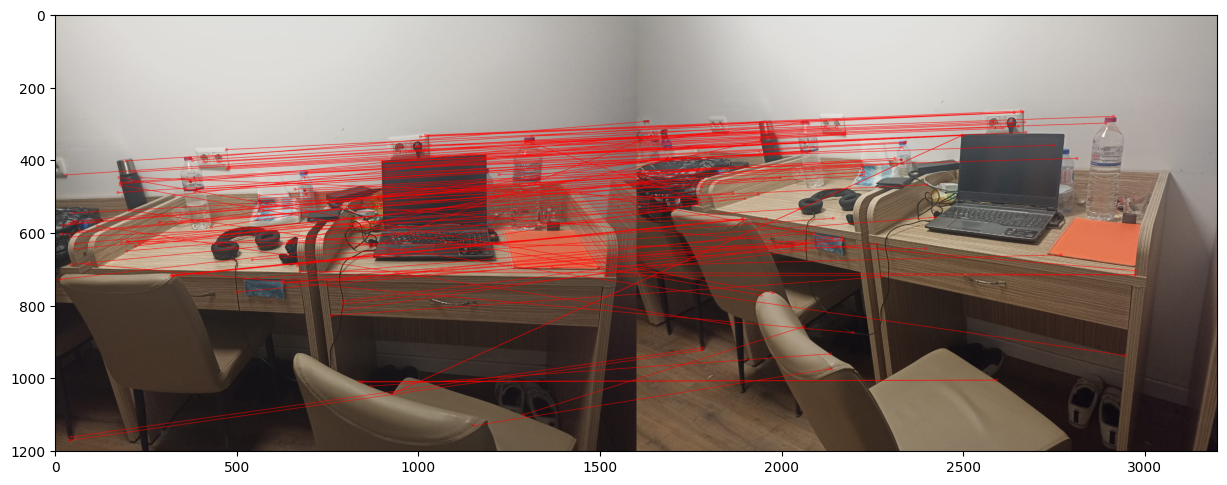

In [135]:
good_matches = eleminate_matches(best_distances, second_best_distances, descriptor2_indexes)
draw_params = dict(matchColor = (255, 0, 0),
                   singlePointColor = None,
                   flags = 2)

final_img = cv2.drawMatches(img_l, keypoints_1, img_r, keypoints_2, good_matches, None, **draw_params)

plt.figure(figsize = (15,9))
plt.imshow(final_img)
plt.show()